# Report Project 1: Navigation

The Bananas environment is solved using a Deep Reinforcement Learning Agent that is very similar to the DQN Agent used for OpenAI Gym's LunarLander-v2. Please check [here](https://github.com/udacity/deep-reinforcement-learning/tree/master/dqn/solution) for the original source code.


## 1. Implementation
The implementation consists of the following components
- a IPython Notebook `Navigation.ipynb` that instantiates the Unity environment (having a 37-dimensional state space and 4 possible actions) and then the DQN Agent using `Agent(state_size=37, action_size=4, seed=0)`. It  basically organizes the communication between agent and environment by exchanging states, actions and rewards.
- a file `dqn_agent.py` implementing the `Agent`-class. The most important methods called from the IPython Notebook are
    - `act` that is used to get the next action of the agent and
    - `step` that is used to feed back the reward and new state to the agent.
- a file `model.py` that implements a feed-forward neural network with two hidden layers. More details on the machine learning model are given in the next section.

## 2. Learning Algorithm

At the heart of the agent is a feed-forward neural network with two hidden layers an ReLU activations. The input layer has 37 neurons corresponding to the dimensionality of the state space. The output layer has 4 output neurons corresponding to the 4 possible actions the agent can take. The hidden layers have 64 neurons.

The DQN agent uses a replay buffer size of 10.000 and triggers an update of the neural network every 4 steps with a batch size of 64 `(state, action, reward, new_state, done)`-tuples from the replay buffer. We need fixed Q-targets to compute our MSE loss properly. Then, the target weights are updated with a soft update with paramter tau=10e-3, which sounds very slow, but given that the learning is triggered every 4 steps the update procedure gets called frequently.

We use an Adam optimizer with a learning rate of 5e-4 and future rewards are discounted with 0.99. The latter parameter has no actual meaning (I guess it could also be 1.0), but as it was used like this in the Lunar Lander code I suppose it is best practice.

## 3. Plot of Rewards

I initially stopped the learning when the agent had a score of at least 13 on average. However, this was a bit early and when watching the agent in action I found there were some really bad episodes when the agent tilted back and forth between a blue banana and the boundary. That is why I aimed a bit higher and required a score of 16 solve the environment. This was actually achieved in 953 episodes:

```
Episode 100	Average Score: 1.15
Episode 200	Average Score: 5.15
Episode 300	Average Score: 7.89
Episode 400	Average Score: 10.92
Episode 500	Average Score: 13.95
Episode 600	Average Score: 14.55
Episode 700	Average Score: 15.26
Episode 800	Average Score: 14.91
Episode 900	Average Score: 14.96
Episode 1000	Average Score: 15.67
Episode 1053	Average Score: 16.04
Environment solved in 953 episodes!	Average Score: 16.04
```

The corresponding **plot** can be found in the cell of the Section [Train the Agent with DQN](#2.-Train-the-Agent-with-DQN)



## 4. Ideas for Future Work

- I think it would be nice to display the current score in the Unity environment
- Similar to the [Rainbow paper](https://arxiv.org/abs/1710.02298), we could implement some additional features
    - Double DQN (DDQN)
    - Prioritized experience replay
    - Dueling DQN
    - multi-step bootstrap targets 
    - Distributional DQN
    - Noisy DQN
- Also creating an agent learning from raw pixels would of course be awesome

# IPython Notebook
---

You can either train the agent yourself or let it run based on weights that I saved. No matter how you decide, the following cells for the setup have to be executed.

## 1. Setup phase


### 1.1. Necessary Imports

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from dqn_agent import Agent
import time
from collections import deque
import matplotlib.pyplot as plt
import torch

### 2. Initiating the Unity environment

The following lines print some information about the environment.

In [2]:
env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


## 2. Train the Agent with DQN
Training the agent takes a bit of patience, but typically not more than 500 episodes are needed to collect more than 13 bananas on average over 100 runs. The weights in the file `checkpoint.pth` were computed over 1053 episodes resulting in an average of 16 bananas over the last 100 runs.

Episode 100	Average Score: 1.15
Episode 200	Average Score: 5.15
Episode 300	Average Score: 7.89
Episode 400	Average Score: 10.92
Episode 500	Average Score: 13.95
Episode 600	Average Score: 14.55
Episode 700	Average Score: 15.26
Episode 800	Average Score: 14.91
Episode 900	Average Score: 14.96
Episode 1000	Average Score: 15.67
Episode 1053	Average Score: 16.04
Environment solved in 953 episodes!	Average Score: 16.04


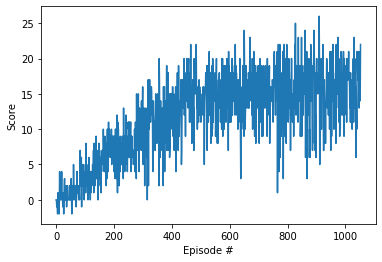

In [3]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            score += reward                                # update the score

            agent.step(state, action, reward, next_state, done)

            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break
            
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

agent = Agent(state_size=37, action_size=4, seed=0)
scores = dqn(n_episodes=2000)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

The last plot shows the increasing average reward per episode (over the last 100 episodes).

## 3. Watch the agent in Action 
Now it's time to see the agent in action. If you ran the code in step 2 it will be based on your trained weights, otherweise it will be based on the pretrained weights in the repository. Please not that there is a command

```
time.sleep(.1)
```

in the next block of code that slows down the simulations. Feel free to increase or decrease the delay per time step.

In [4]:
agent = Agent(state_size=37, action_size=4, seed=0)
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    #action = np.random.randint(action_size)        # select an action
    action = agent.act(state)
    #print(state, action)
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    time.sleep(.1)
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 15.0


When done, the following call closes the Unity environment.

In [5]:
env.close()